In [1]:
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
# %matplotlib nbagg
# %matplotlib inline
plt.style.use(["seaborn-deep", "seaborn-whitegrid"])

In [23]:
import torch
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from functools import reduce

# The digit classes to use, these need to be in order because
# we are using one-hot representation
classes = np.arange(2)

def one_hot(labels):
    y = torch.eye(len(classes)) 
    return y[labels]

# Define the train and test sets
dset_train = MNIST("./", train=True, download=True, transform=ToTensor(), target_transform=one_hot)
dset_test  = MNIST("./", train=False, transform=ToTensor(), target_transform=one_hot)

def stratified_sampler(labels):
    """Sampler that only picks datapoints corresponding to the specified classes"""
    (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))
    indices = torch.from_numpy(indices)
    return SubsetRandomSampler(indices)


batch_size = 64
# The loaders perform the actual work
train_loader = DataLoader(dset_train, batch_size=batch_size,
                          sampler=stratified_sampler(dset_train.train_labels), pin_memory=cuda, drop_last = True)
test_loader  = DataLoader(dset_test, batch_size=batch_size, 
                          sampler=stratified_sampler(dset_test.test_labels), pin_memory=cuda, drop_last = True)

# for x, _ in train_loader:
#     print(x.size(0))


d:\Users\karl\anaconda3\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
d:\Users\karl\anaconda3\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [24]:
import torch
import torch.nn as nn
import numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class Maxout(nn.Module):
    def __init__(self, in_features, out_features, num_pieces):
        super(Maxout, self).__init__()

        self.in_features = in_features
        self.out_features = out_features
        self.num_pieces = num_pieces

        self.lin = nn.Linear(in_features, out_features * num_pieces)

    def forward(self, x):
        lin = self.lin(x)
        y = lin.view(-1, self.num_pieces, self.out_features).max(dim=1)[0]
        return y

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class Generator(nn.Module):
    def __init__(self, num_input):
        super(Generator, self).__init__()
        self.Net = nn.Sequential(
            nn.Linear(num_input, 1200), # [bz, 1, 100] -> [bz, 1, 256]
            nn.ReLU(),
            nn.Linear(1200, 1200),
            nn.ReLU(),
            nn.Linear(1200, 1200),
            nn.ReLU(),
            nn.Linear(1200, 28 * 28), # [bz, 1, 1024] -> [bz, 1, 28 * 28]
            nn.Sigmoid() # Image intensities are in [0, 1]
        )

    def forward(self, input):
        output = Flatten()(input)
        output = torch.unsqueeze(output, dim=1)
        output = self.Net(output)
        output = output.view(input.size(0), 1, 28, 28)
        return output

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # self.Net = nn.Sequential(
        #     nn.Linear(1, 64), # [bz, 1, 28, 28] -> [bz, 28 * 28, 1] -> [bz, 28* 28, 64]
        #     nn.LeakyReLU(0.2),
        #     nn.Dropout(0.1),
        #     nn.Linear(64, 128),
        #     nn.LeakyReLU(0.2),
        #     nn.Dropout(0.1),
        #     nn.Linear(128, 256),
        #     nn.LeakyReLU(0.2),
        #     nn.Dropout(0.1),
        #     nn.Linear(256, 1), # [bz, 28* 28, 1]
        #     nn.Dropout(0.1),
        #     Flatten(), # [bz, 28 * 28] 2D tensor
        #     nn.Linear(784, 1), #[bz, 1]
        #     nn.Sigmoid()
        # )
        self.max1 = nn.Sequential(
            Maxout(784, 240, 5),
            nn.Dropout(0.8)
        )
        self.max2 = nn.Sequential(
            Maxout(240, 240, 5),
            # nn.Dropout(0.8)
        )
        self.lin1 = nn.Sequential(
            nn.Linear(240, 1),
            # nn.Dropout(0.8),
            nn.Sigmoid()
        )
        
    def forward(self, input):
        # input = torch.unsqueeze(Flatten()(input), dim=-1)
        input = Flatten()(input)
        output = self.lin1(self.max2(self.max1(input)))
        return output


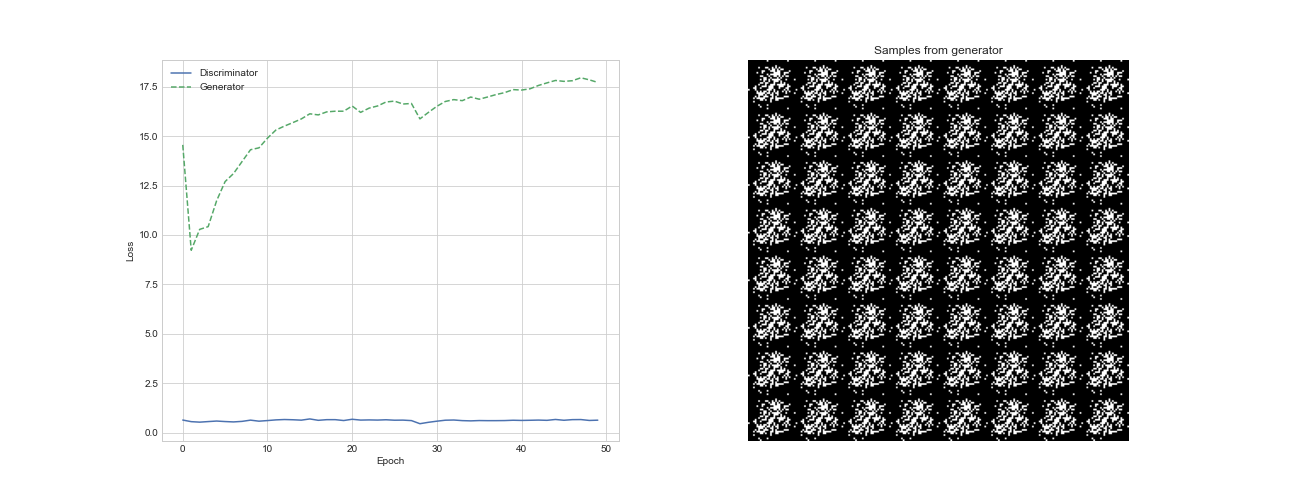

In [25]:
from torch.autograd import Variable
import os
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import torch
import numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'

latent_dim = 100
discriminator = Discriminator().to(device)
generator = Generator(latent_dim).to(device)

loss = torch.nn.BCELoss()
print("Using device:", device)

generator_optim = torch.optim.SGD(generator.parameters(), 0.1, momentum=0.5)
discriminator_optim = torch.optim.SGD(discriminator.parameters(), 0.1, momentum=0.5)
tmp_img = "tmp_gan_out.png"
discriminator_loss, generator_loss = [], []

num_epochs = 50
for epoch in range(num_epochs):
    batch_d_loss, batch_g_loss = [], []

    for x, _ in train_loader:
        batch_size = x.size(0)
        # True data is given label 1, while fake data is given label 0
        true_label = torch.ones(batch_size, 1).to(device)
        fake_label = torch.zeros(batch_size, 1).to(device)

        discriminator.zero_grad()
        generator.zero_grad()

        # Step 1. Send real data through discriminator
        #         and backpropagate its errors.
        x_true = Variable(x).to(device)
        output = discriminator(x_true)

        error_true = loss(output, true_label)
        error_true.backward()

        # Step 2. Generate fake data G(z), where z ~ N(0, 1)
        #         is a latent code.
        z = torch.randn(batch_size, latent_dim, 1, 1)
        z = Variable(z, requires_grad=False).to(device)
        x_fake = generator(z)

        # Step 3. Send fake data through discriminator
        #         propagate error and update D weights.
        # --------------------------------------------
        # Note: detach() is used to avoid compounding generator gradients
        output = discriminator(x_fake.detach())

        error_fake = loss(output, fake_label)
        error_fake.backward()
        discriminator_optim.step()

        # Step 4. Send fake data through discriminator _again_
        #         propagate the error of the generator and
        #         update G weights.
        output = discriminator(x_fake)

        error_generator = loss(output, true_label)
        error_generator.backward()
        generator_optim.step()

        batch_d_loss.append((error_true / (error_true + error_fake)).item())
        batch_g_loss.append(error_generator.item())

    discriminator_loss.append(np.mean(batch_d_loss))
    generator_loss.append(np.mean(batch_g_loss))

    # -- Plotting --
    f, axarr = plt.subplots(1, 2, figsize=(18, 7))

    # Loss
    ax = axarr[0]
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')

    ax.plot(np.arange(epoch + 1), discriminator_loss)
    ax.plot(np.arange(epoch + 1), generator_loss, linestyle="--")
    ax.legend(['Discriminator', 'Generator'])

    # Latent space samples
    ax = axarr[1]
    ax.set_title('Samples from generator')
    ax.axis('off')

    rows, columns = 8, 8

    # Generate data
    with torch.no_grad():
        z = torch.randn(batch_size, 1, latent_dim)
        z = Variable(z, requires_grad=False).to(device)
        x_fake = generator(z)

    canvas = np.zeros((28 * rows, columns * 28))
    for i in range(rows):
        for j in range(columns):
            idx = i % columns + rows * j
            canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = x_fake.cpu().data[idx]
    ax.imshow(canvas, cmap='gray')

    plt.savefig(tmp_img)
    plt.close(f)
    display(Image(filename=tmp_img))
    clear_output(wait=True)

    os.remove(tmp_img)

C:\Users\karl\AppData\Local\Temp\ipykernel_20572\184128163.py:107: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, axarr = plt.subplots(1, 2, figsize=(18, 7))


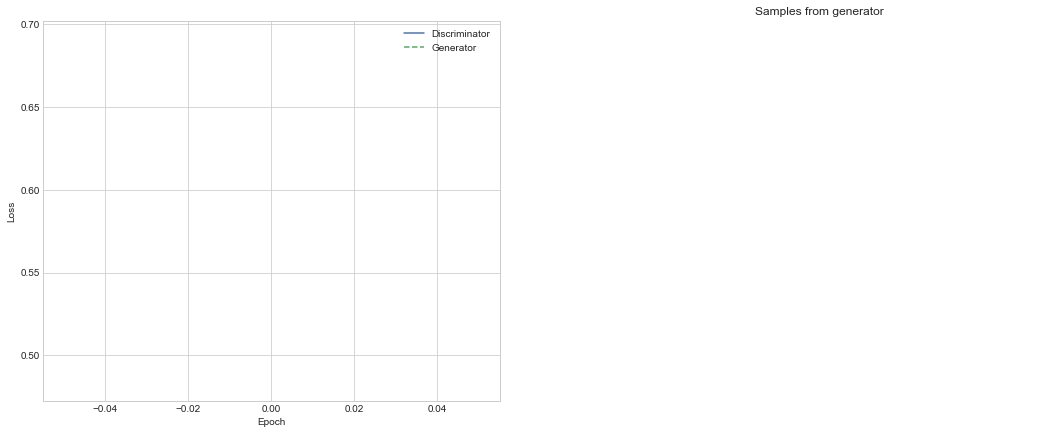

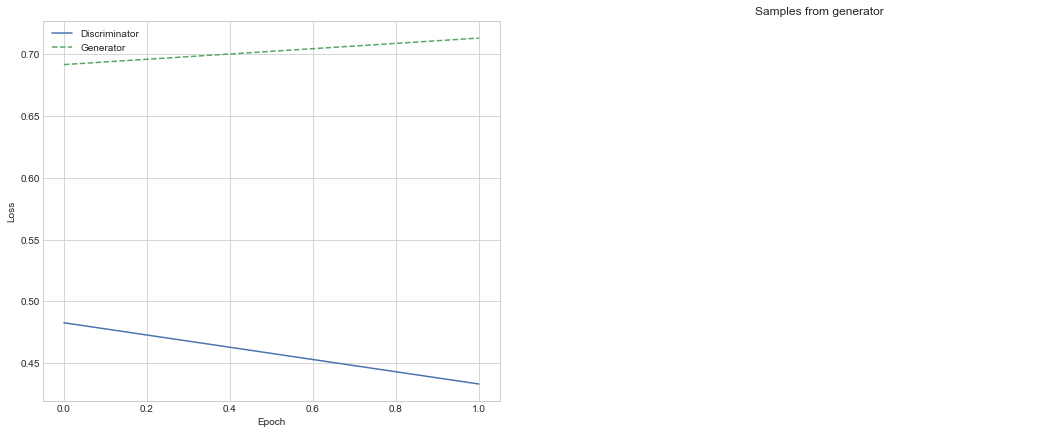

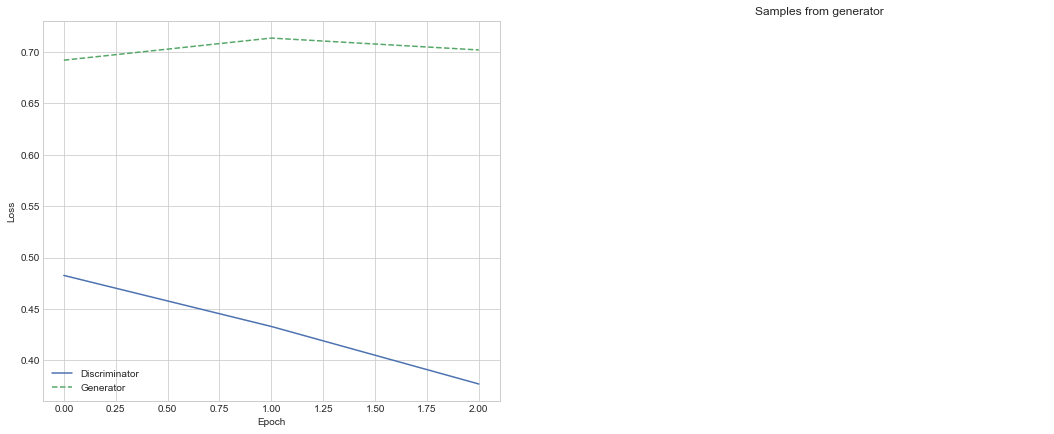

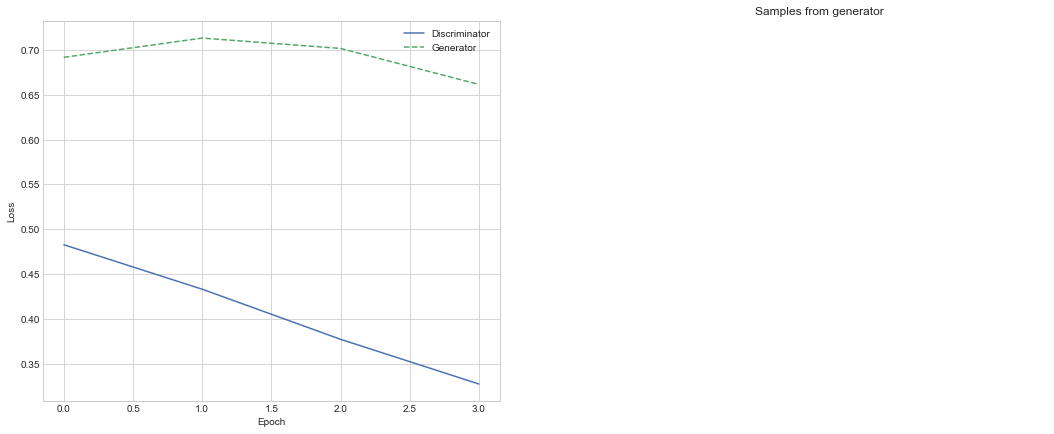

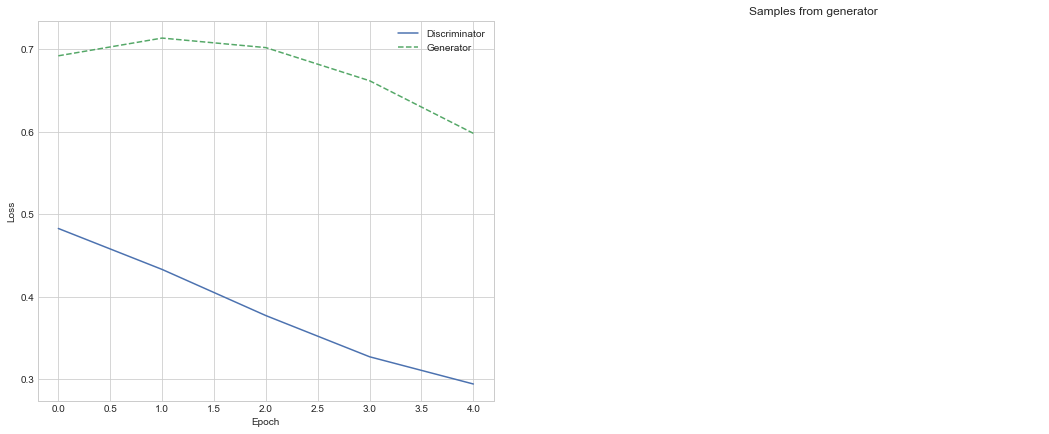

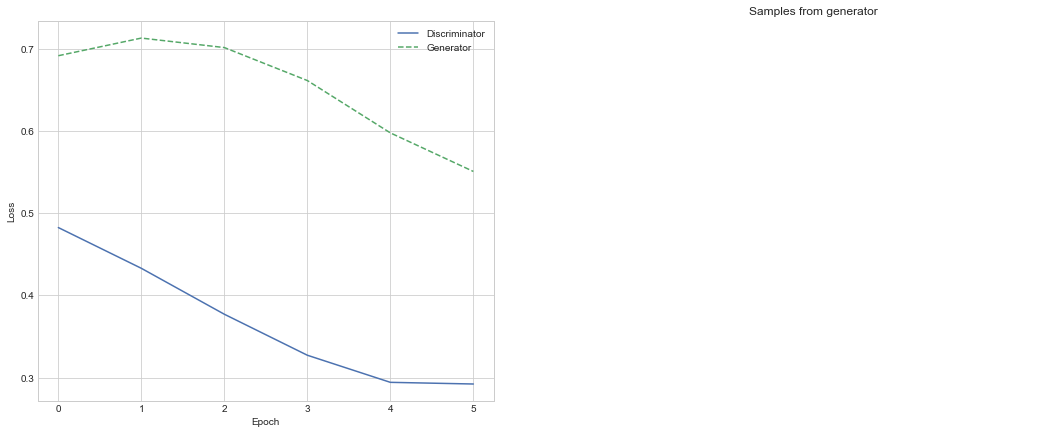

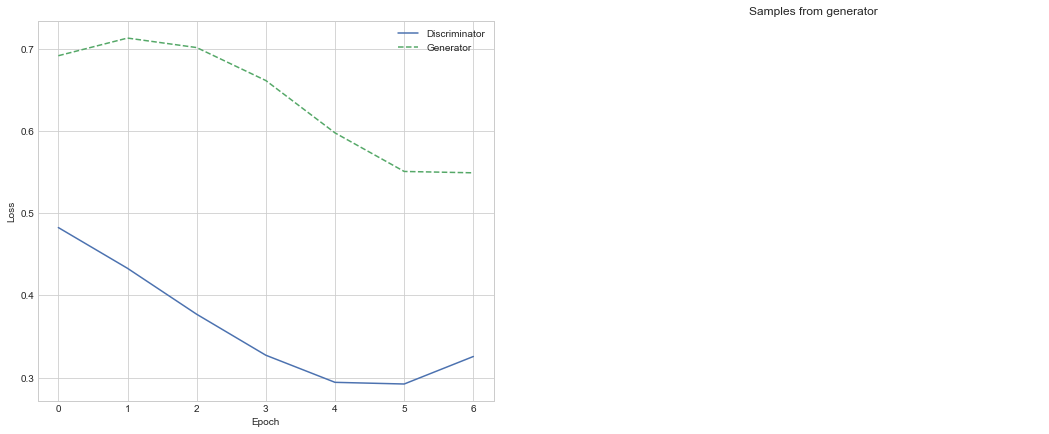

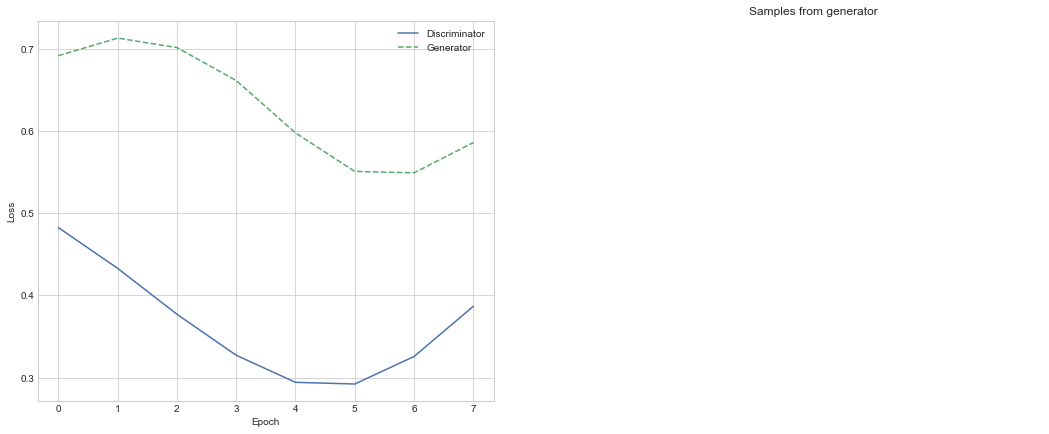

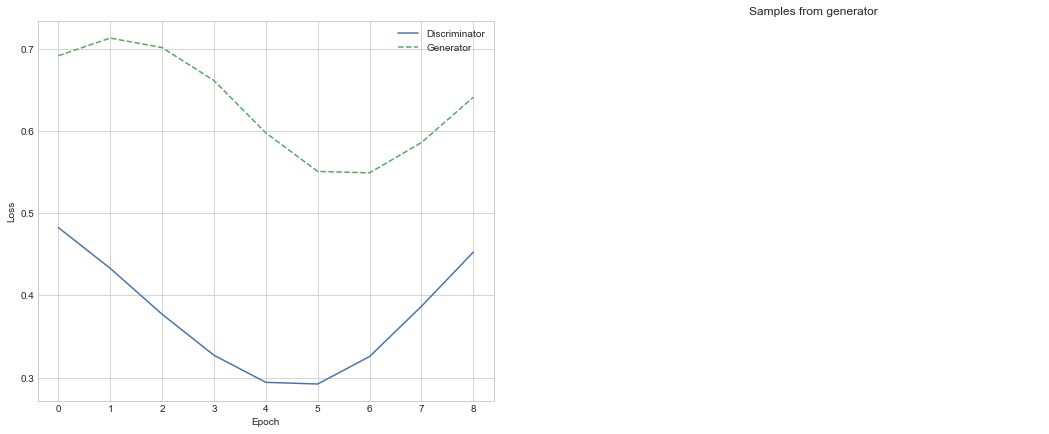

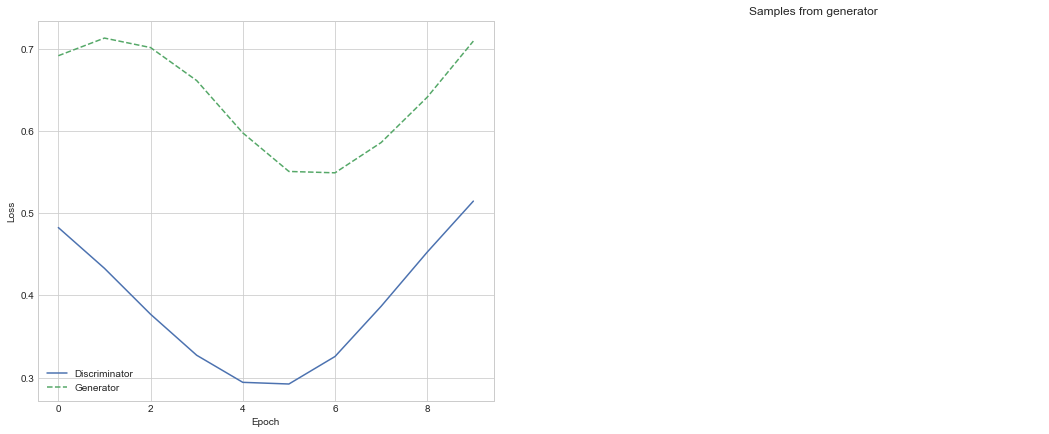

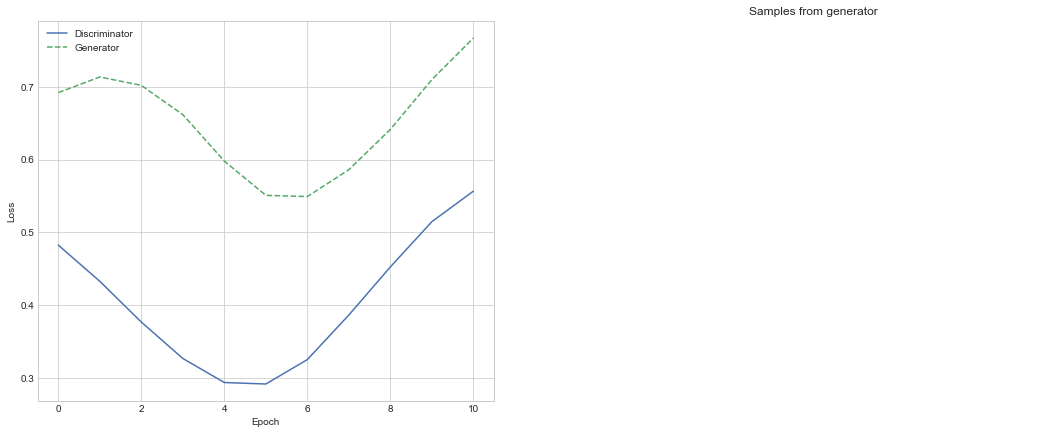

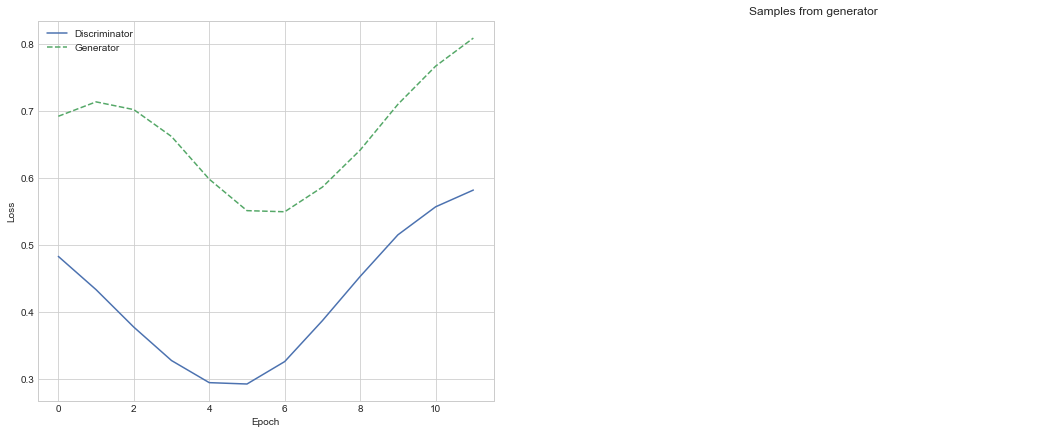

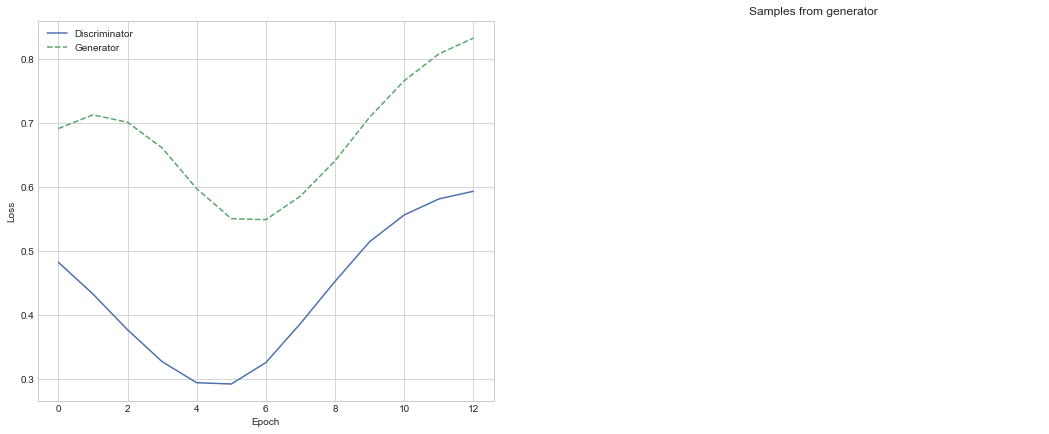

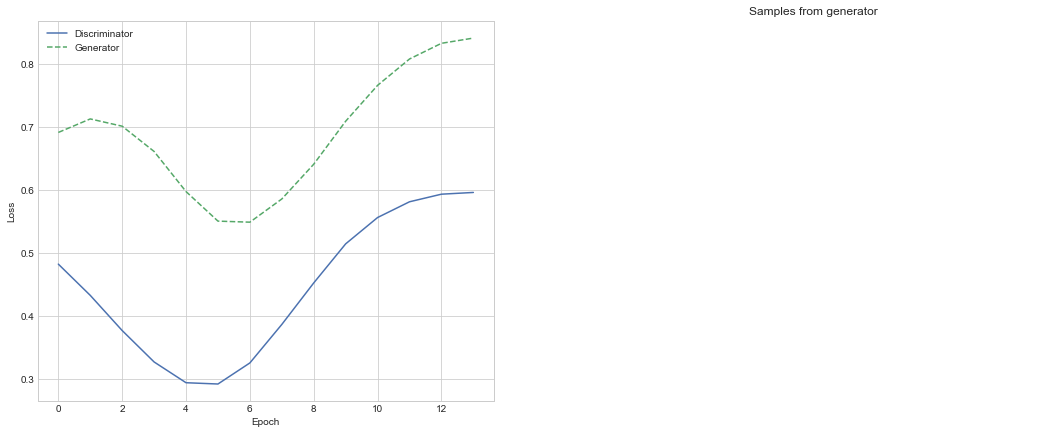

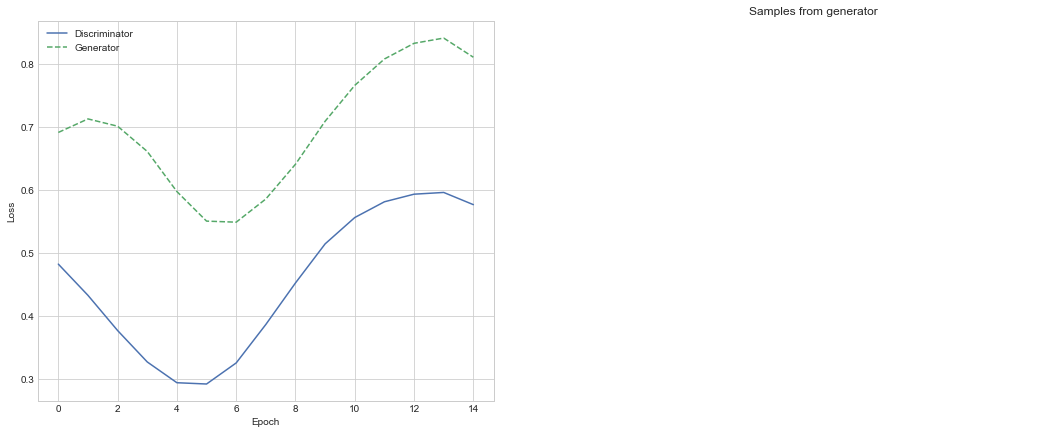

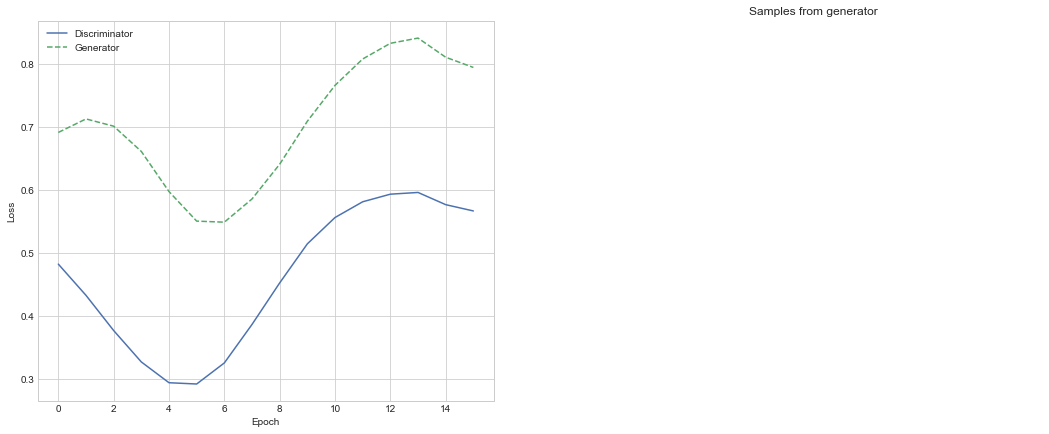

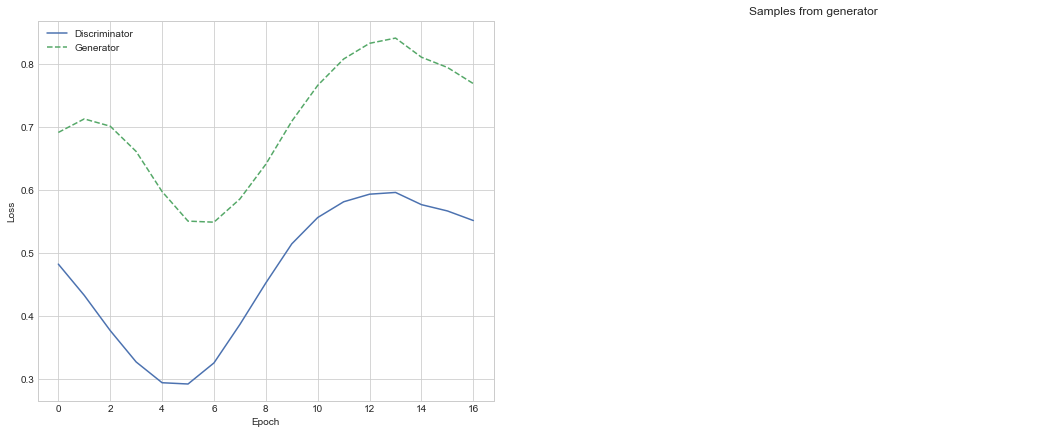

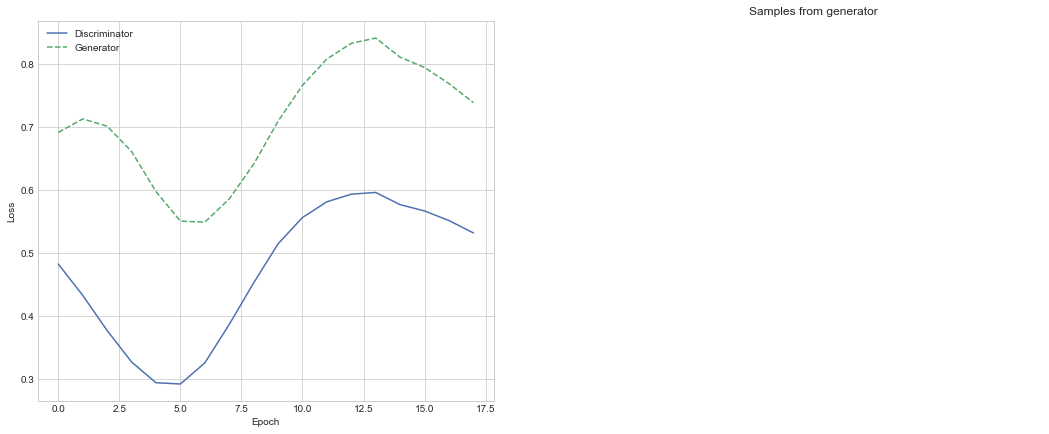

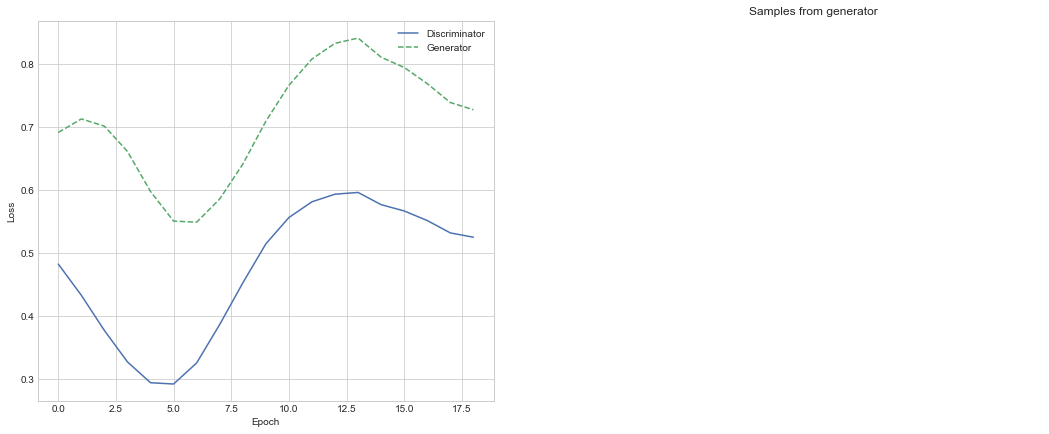

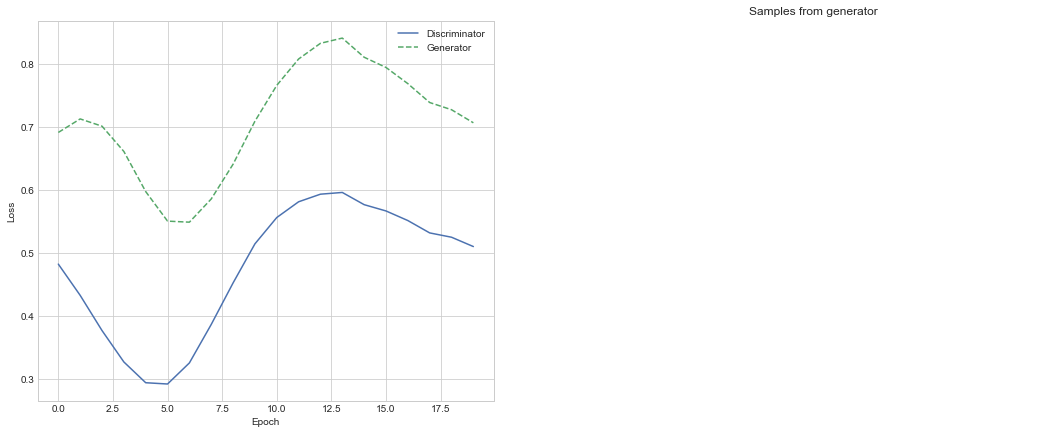

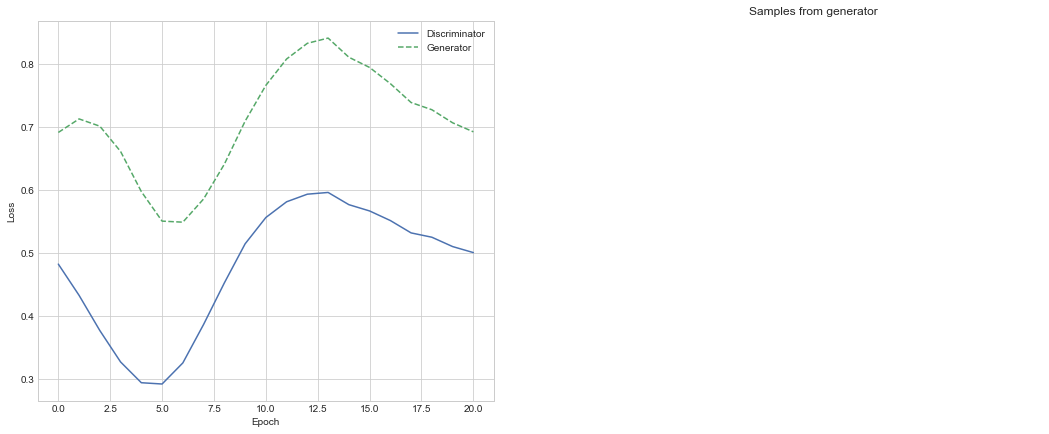

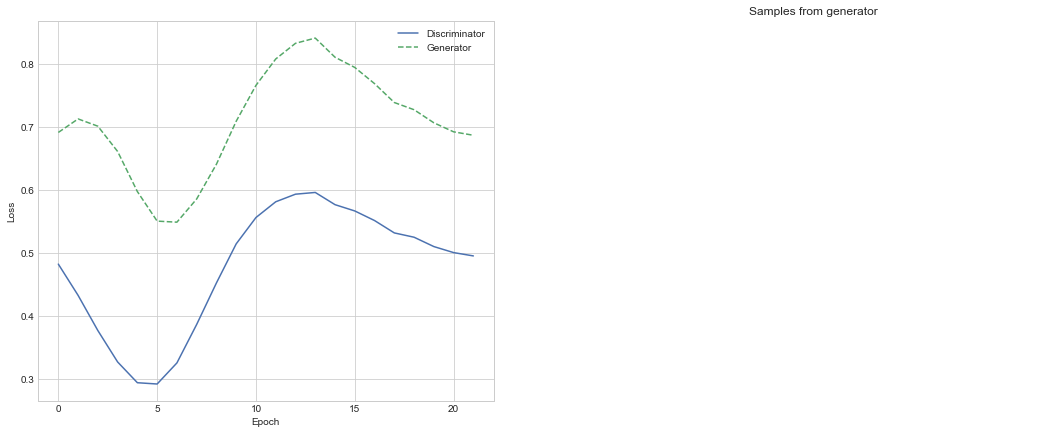

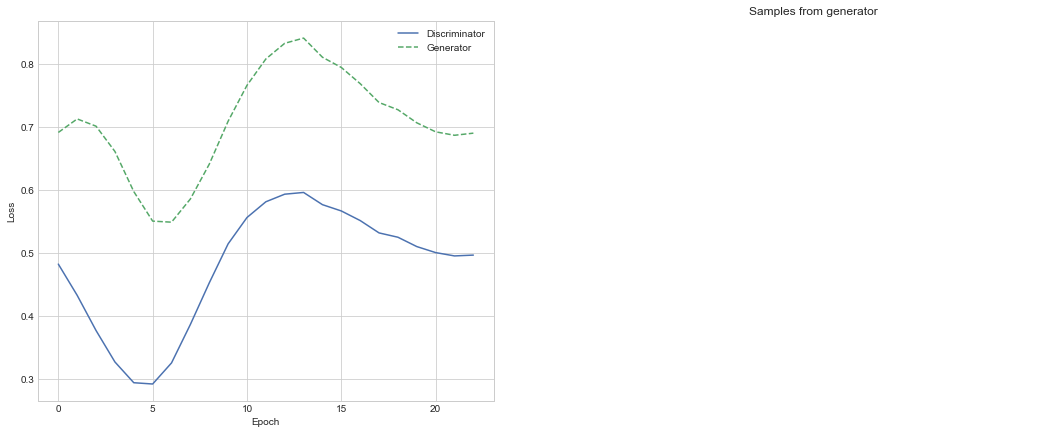

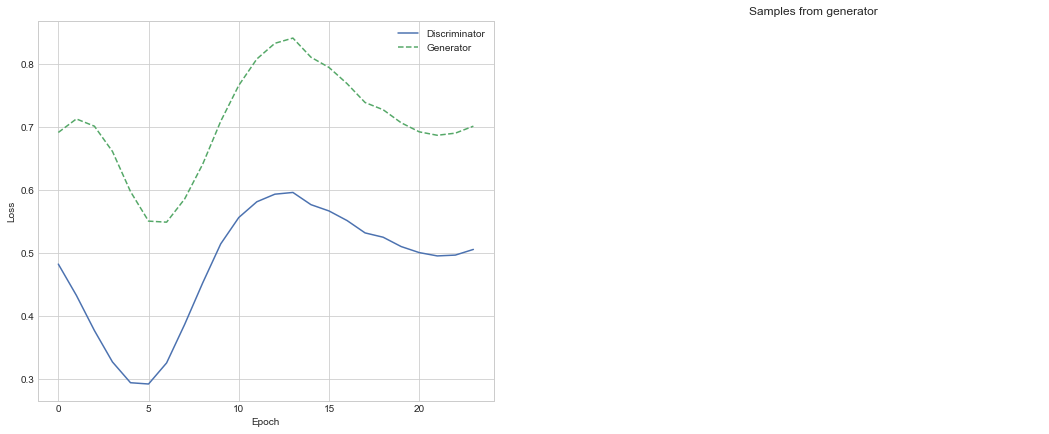

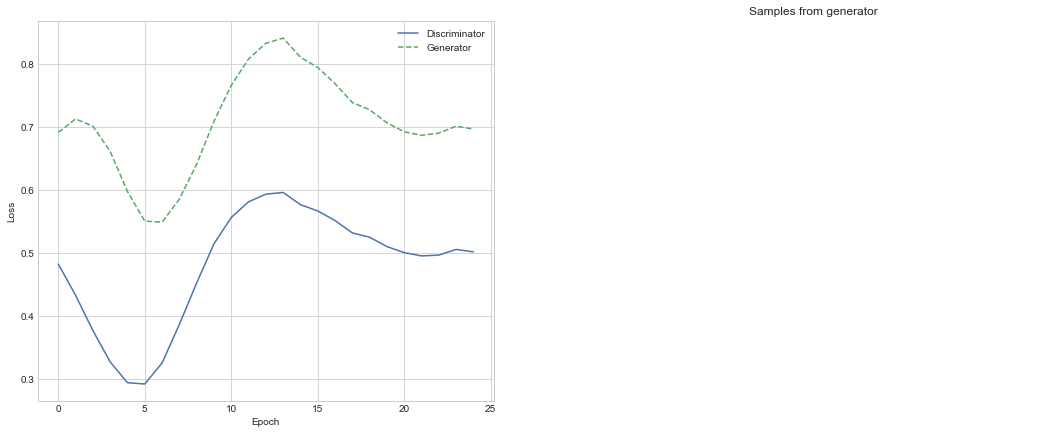

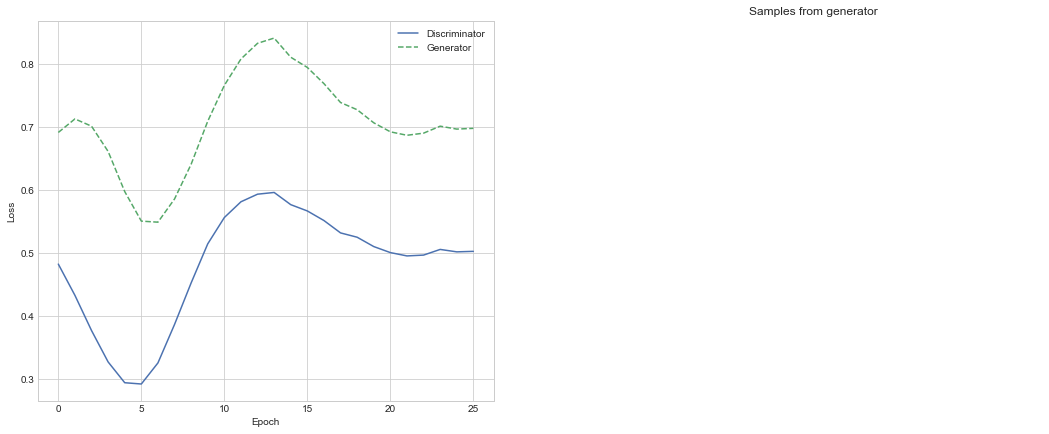

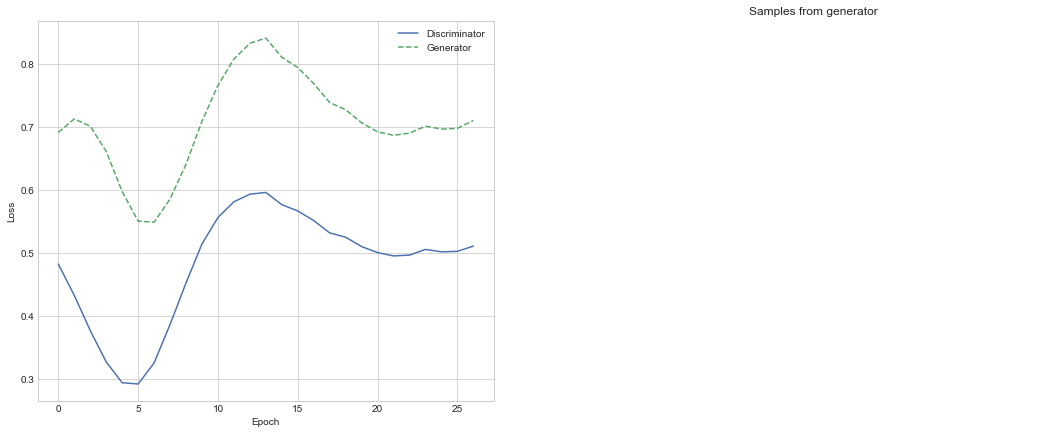

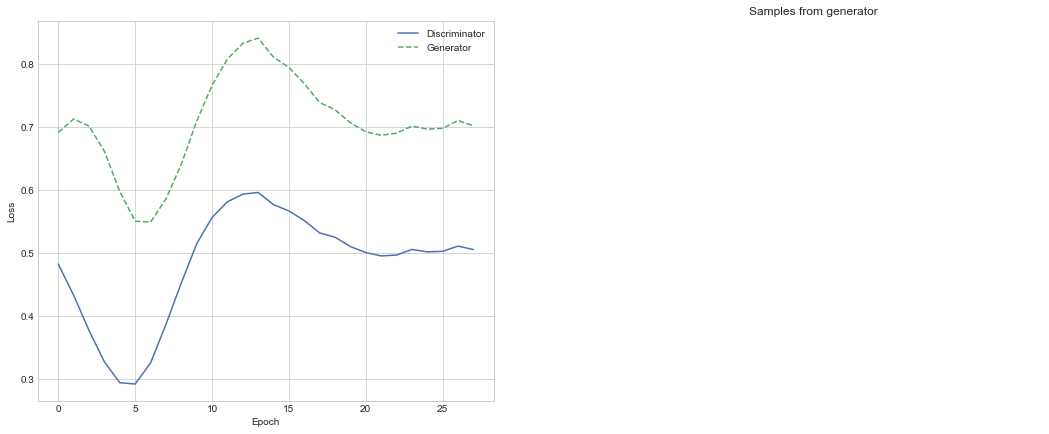

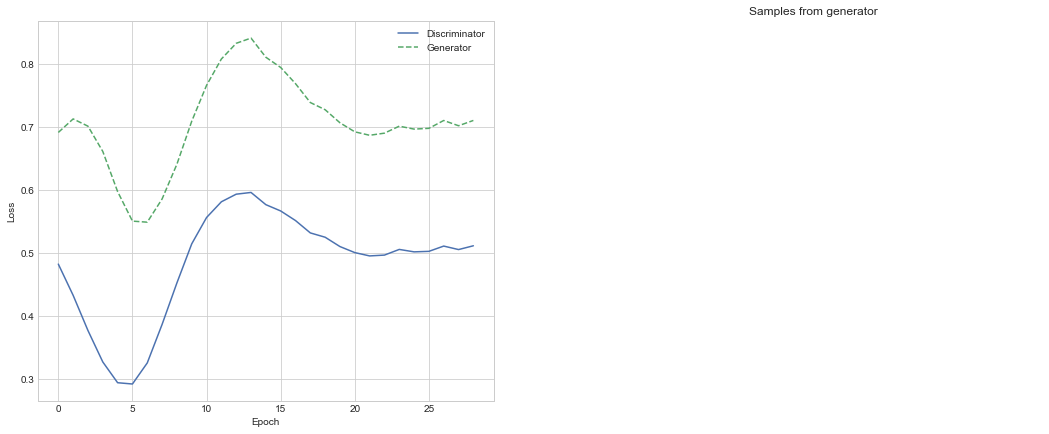

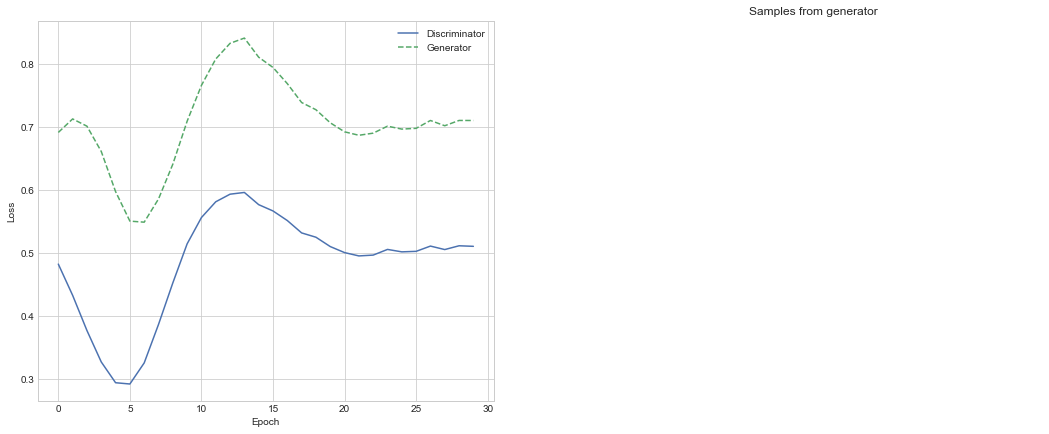

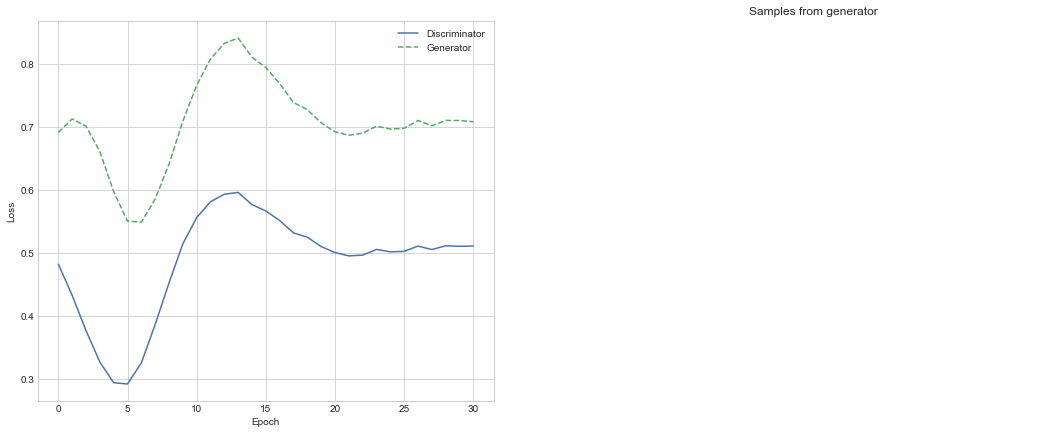

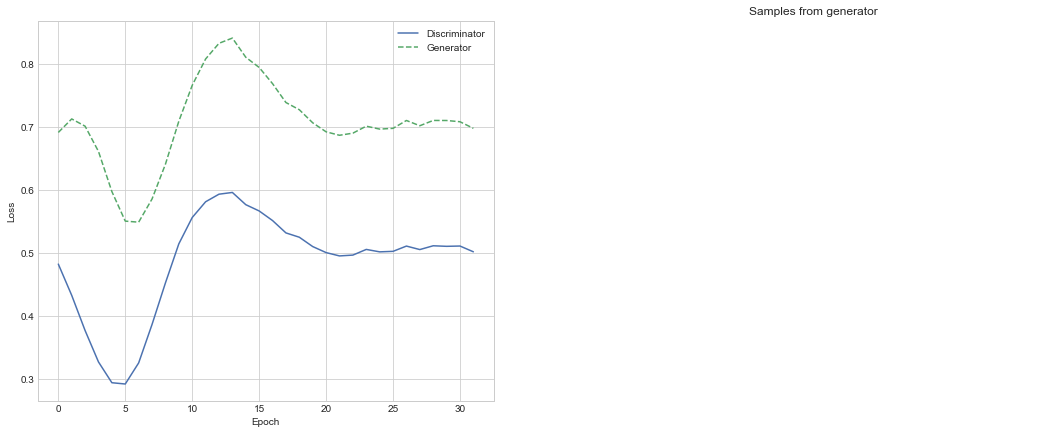

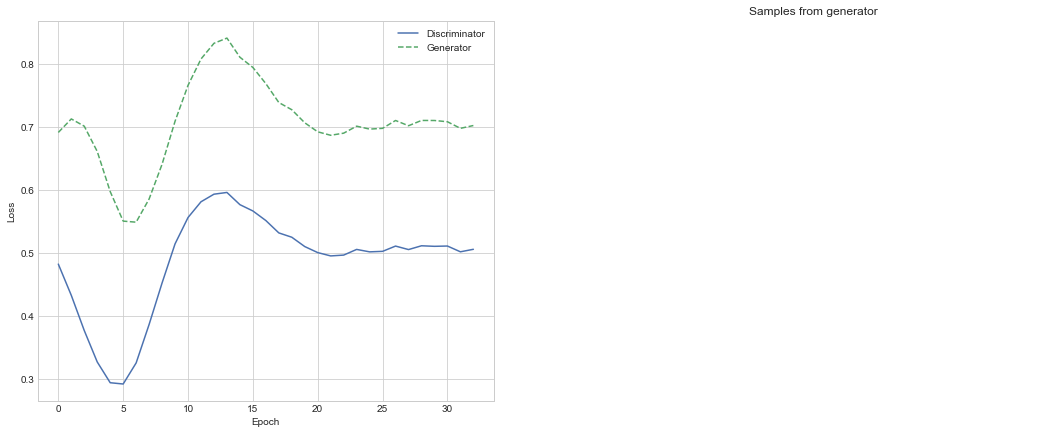

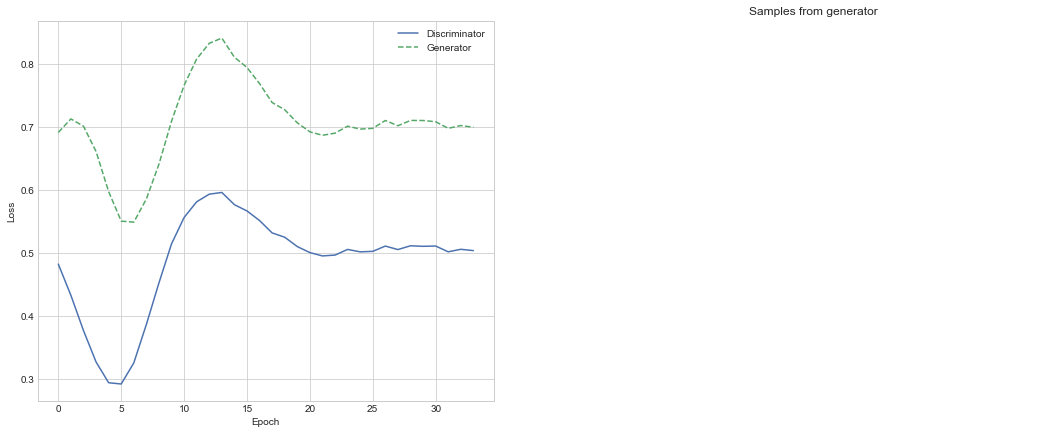

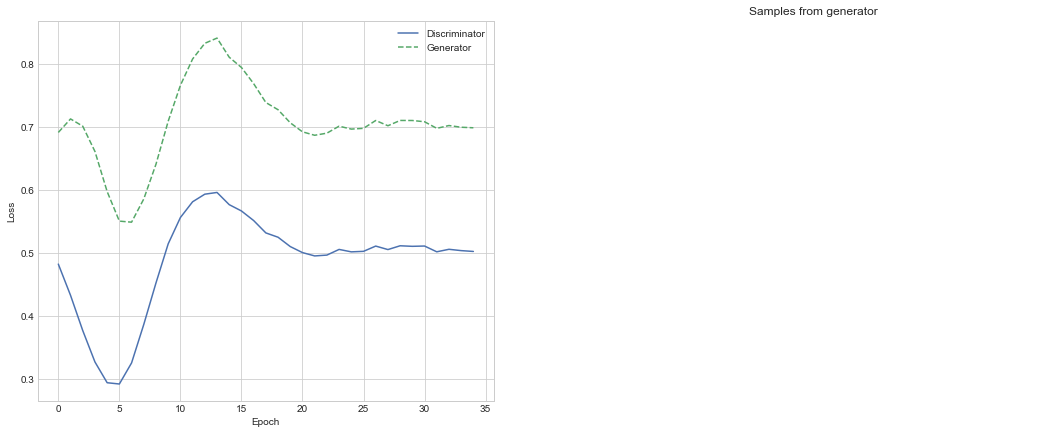

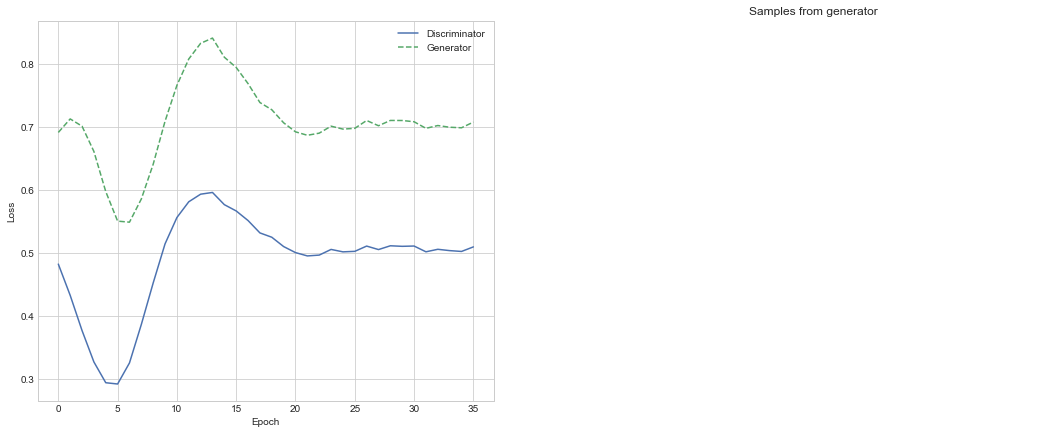

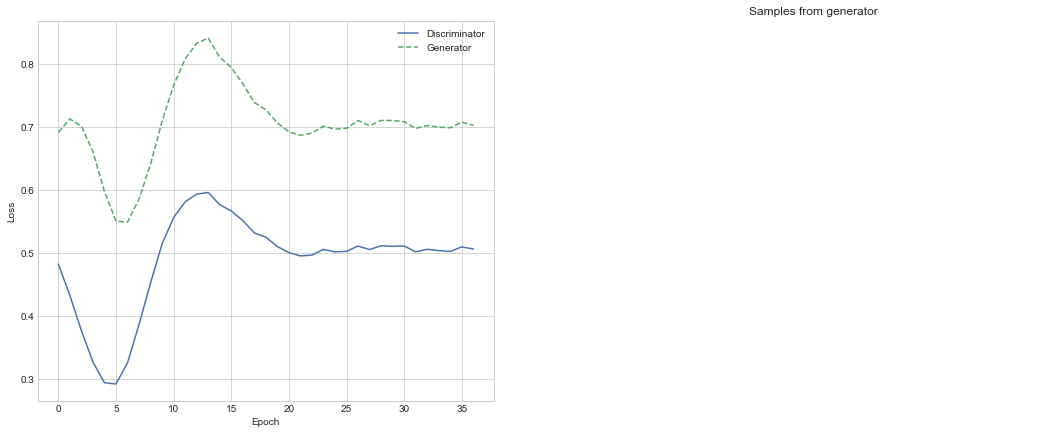

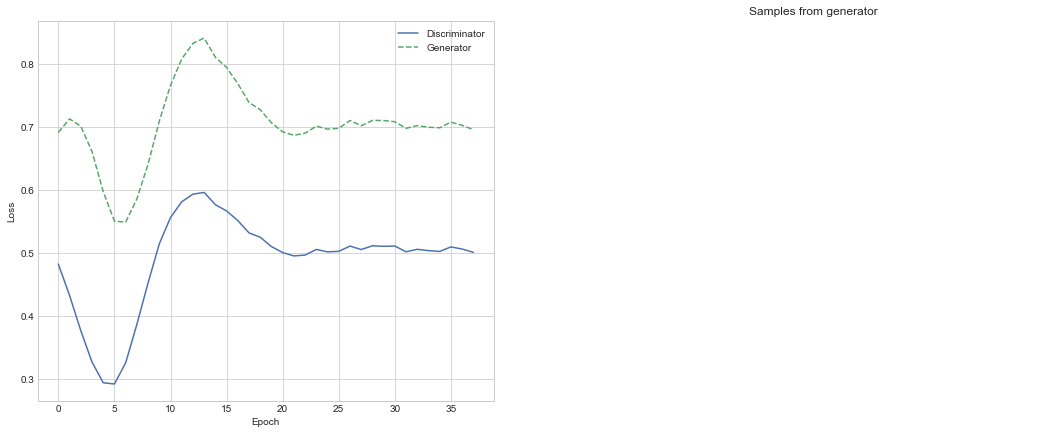

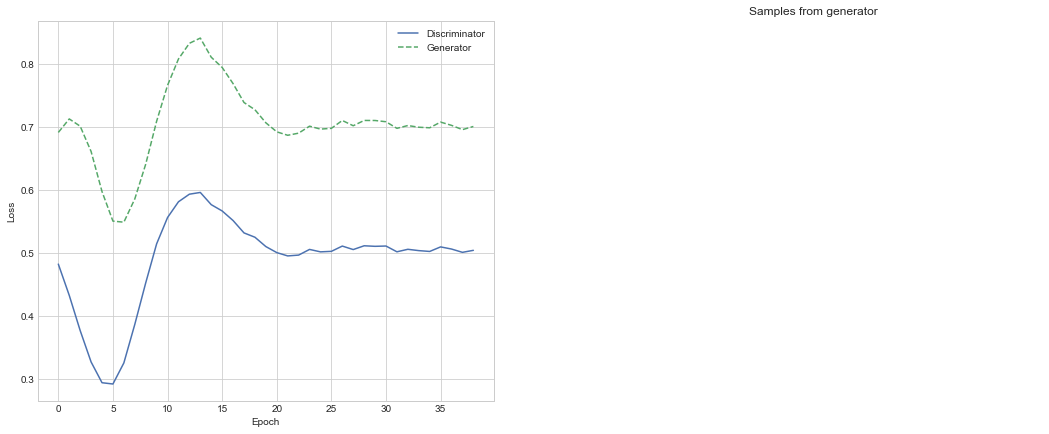

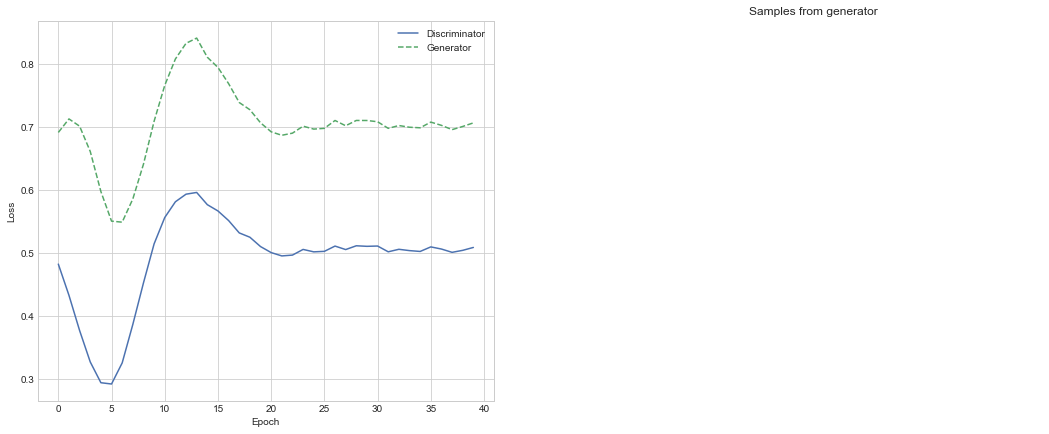

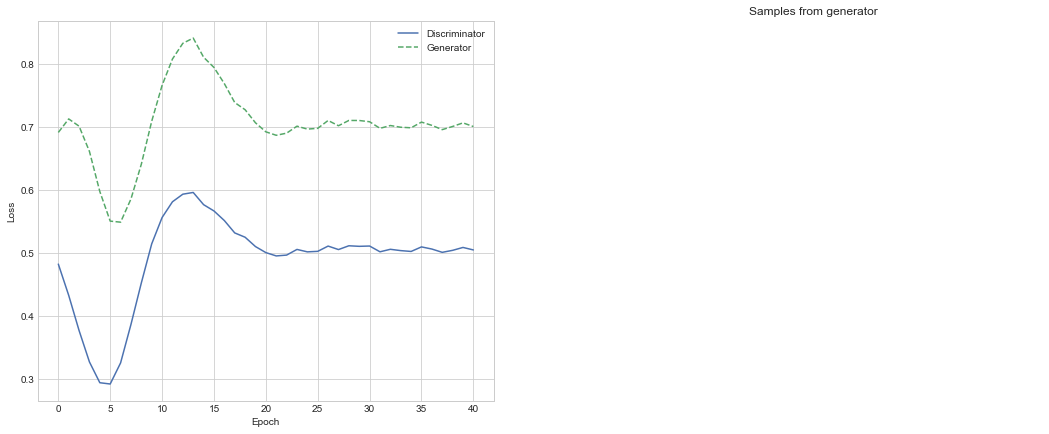

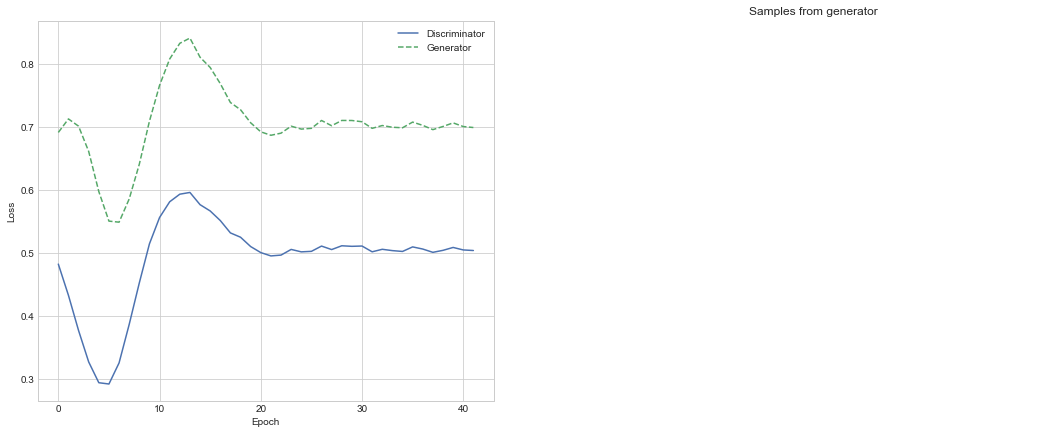

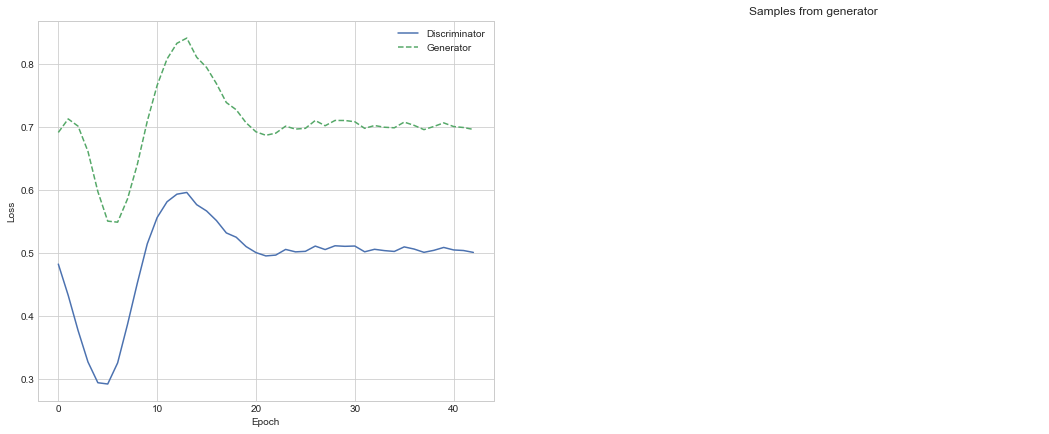

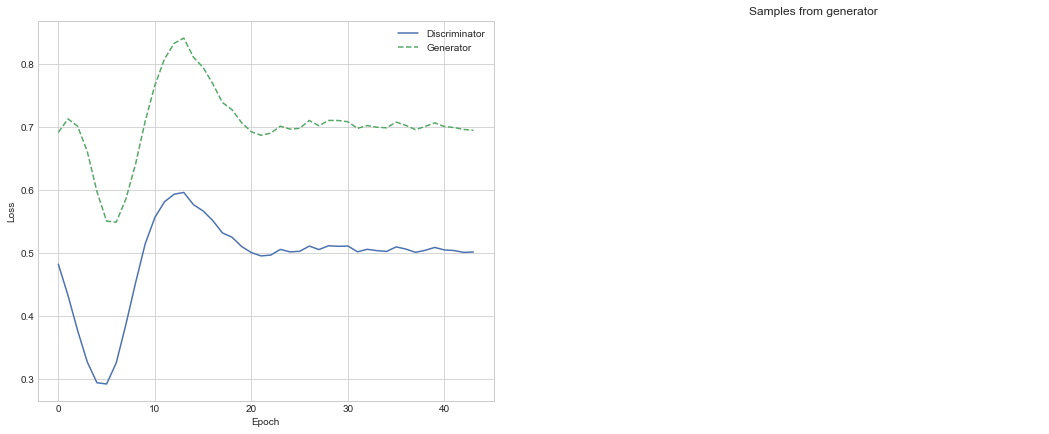

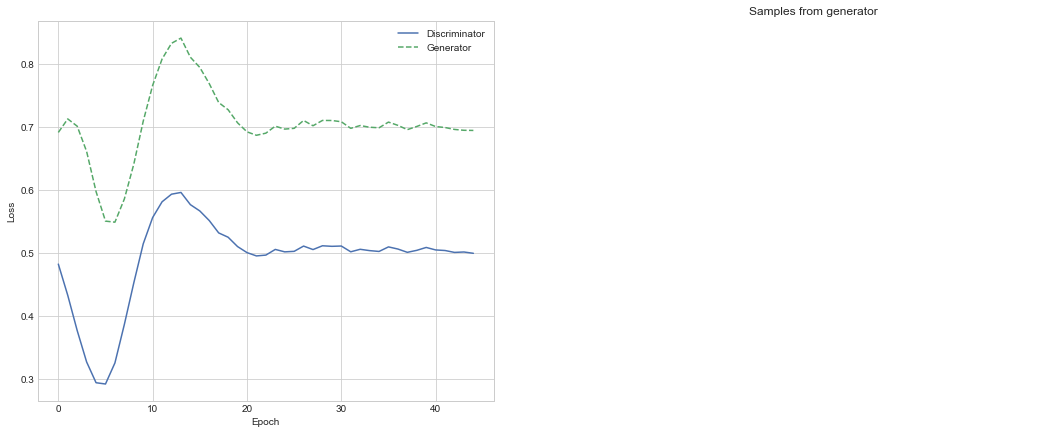

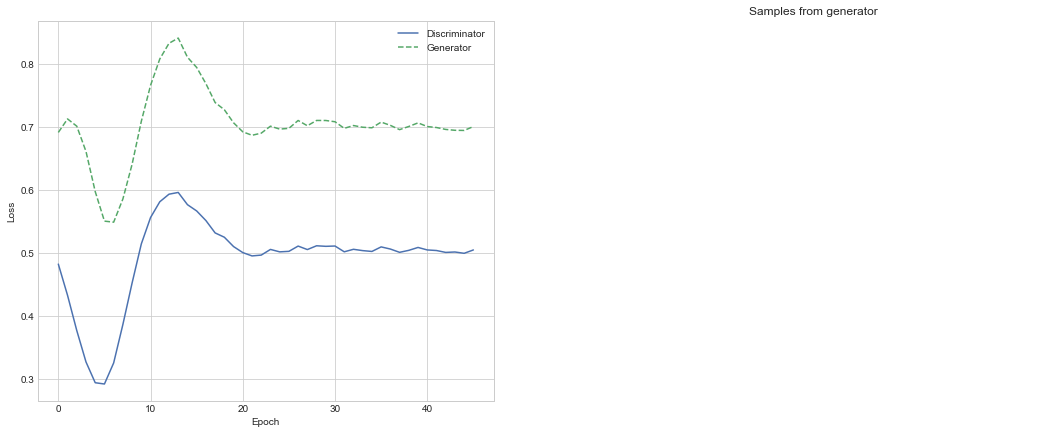

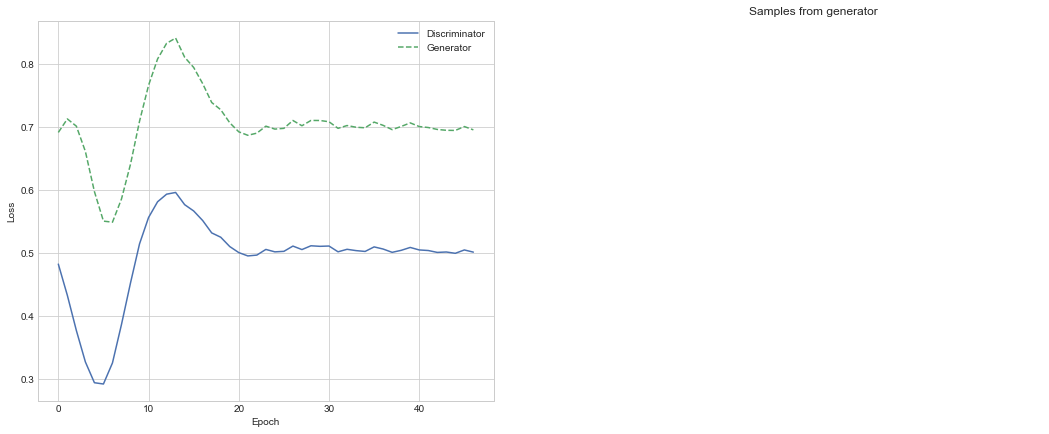

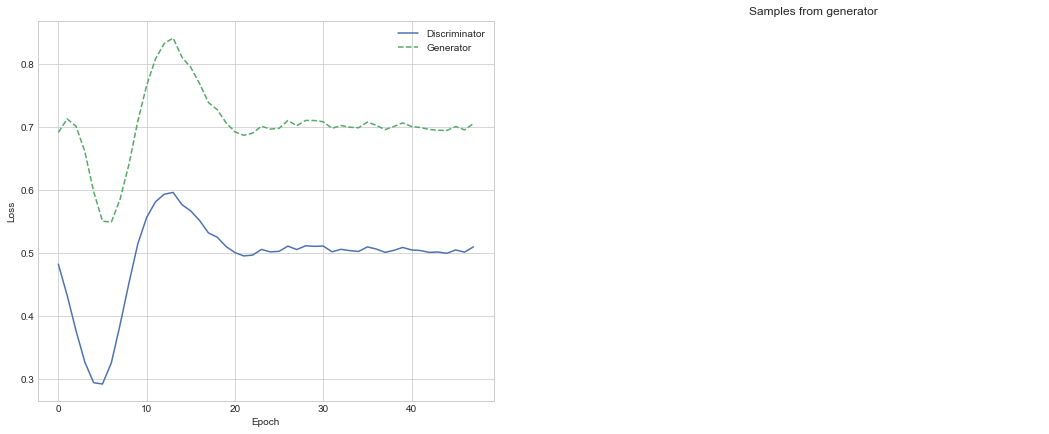

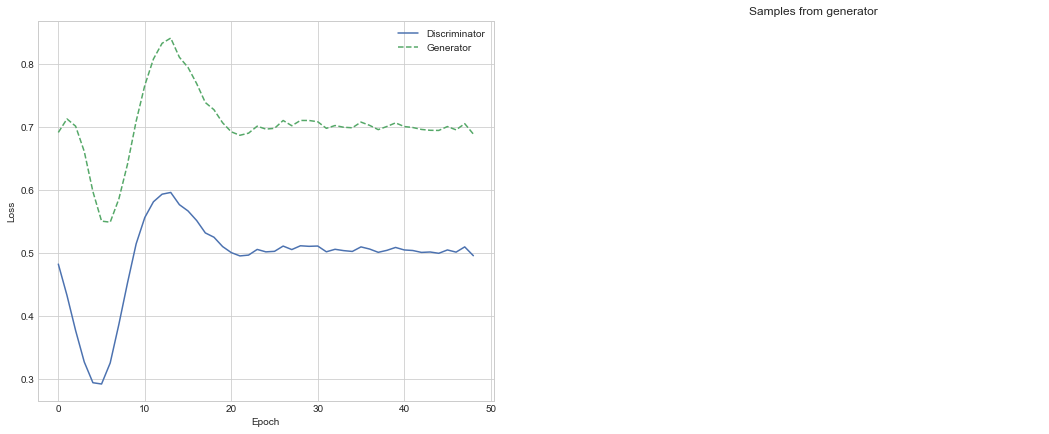

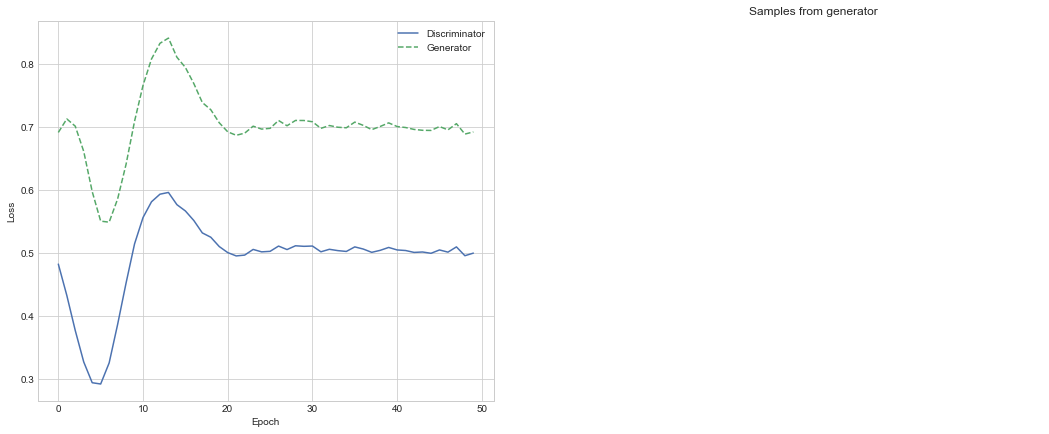

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
from torch.autograd import Variable
from IPython.display import Image, display, clear_output

import os
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def generate_real_data():
    data = []
    for i in range(1024):
        data.append(np.random.randn() + 3.0)
    return np.array(data, dtype=float)

batch_size = 64
data = generate_real_data()
data = data.astype(np.float32)
data = np.reshape(data, (1024, 1))
data = torch.from_numpy(data).to(device)
data = TensorDataset(data, data)
data = DataLoader(data, batch_size=batch_size, shuffle=True)
train_loader = data
latent_dim = 100
generator = nn.Sequential(
    nn.Linear(latent_dim, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 1),
    nn.ReLU()
).to(device)

discriminator = nn.Sequential(
    nn.Linear(1, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 1),
    nn.Sigmoid()
).to(device)

loss = torch.nn.BCELoss()
discriminator_loss, generator_loss = [], []

generator_optim = torch.optim.Adam(generator.parameters(), 2e-4, betas=(0.5, 0.999))
discriminator_optim = torch.optim.Adam(discriminator.parameters(), 2e-4, betas=(0.5, 0.999))

num_epochs = 50
for epoch in range(num_epochs):
    batch_d_loss, batch_g_loss = [], []

    for x, _ in train_loader:
        batch_size = x.size(0)
        # True data is given label 1, while fake data is given label 0
        true_label = torch.ones(batch_size, 1).to(device)
        fake_label = torch.zeros(batch_size, 1).to(device)

        discriminator.zero_grad()
        generator.zero_grad()

        # Step 1. Send real data through discriminator
        #         and backpropagate its errors.
        x_true = Variable(x).to(device)
        output = discriminator(x_true)

        error_true = loss(output, true_label)
        error_true.backward()

        # Step 2. Generate fake data G(z), where z ~ N(0, 1)
        #         is a latent code.
        z = torch.randn(batch_size, latent_dim)
        z = Variable(z, requires_grad=False).to(device)
        x_fake = generator(z)

        # Step 3. Send fake data through discriminator
        #         propagate error and update D weights.
        # --------------------------------------------
        # Note: detach() is used to avoid compounding generator gradients
        output = discriminator(x_fake.detach())

        error_fake = loss(output, fake_label)
        error_fake.backward()
        discriminator_optim.step()

        # Step 4. Send fake data through discriminator _again_
        #         propagate the error of the generator and
        #         update G weights.
        output = discriminator(x_fake)

        error_generator = loss(output, true_label)
        error_generator.backward()
        generator_optim.step()

        batch_d_loss.append((error_true / (error_true + error_fake)).item())
        batch_g_loss.append(error_generator.item())

    discriminator_loss.append(np.mean(batch_d_loss))
    generator_loss.append(np.mean(batch_g_loss))

    f, axarr = plt.subplots(1, 2, figsize=(18, 7))

    # Loss
    ax = axarr[0]
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')

    ax.plot(np.arange(epoch + 1), discriminator_loss)
    ax.plot(np.arange(epoch + 1), generator_loss, linestyle="--")
    ax.legend(['Discriminator', 'Generator'])

    # Latent space samples
    ax = axarr[1]
    ax.set_title('Samples from generator')
    ax.axis('off')

    with torch.no_grad():
        z = torch.randn(batch_size, latent_dim)
        z = Variable(z, requires_grad=False).to(device)
        x_fake = generator(z)
